# Notebook 3: Testing highly variable genes

Goal: Compare different methods for identifying highly variable genes (built into scanpy) and identifying optimal number of features to use

1. Load training dataset with original labels
2. Create cross-fold splits using StratifiedGroupKFold
3. Select highly variable genes using seurat_v3, seurat (v1), Cell Ranger, or analytic Pearson residuals methods
4. Train model using top 20, 50, 100, 200, 500, 1000, 2000, or 5000. Also do the same for randomly selected genes (randomize order of all genes and select top N genes) and differential gene expression.
5. Plot all evaluation metrics for all approaches

In [1]:
import main_functions as mf
import os
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import scanpy as sc
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import textwrap

/home/gylam/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
RANDOM_STATE = 42
CV = 5

In [3]:
# Set up working directory
folder_path = input('Please enter the path of the folder containing datasets: ')
os.chdir(folder_path)

Please enter the path of the folder containing datasets:  ../data/


In [4]:
# Load training dataset into AnnData object
adata_train = sc.read_h5ad('train.h5ad')

In [5]:
# Variables for training

# Parameters for XGBoost model obtained from initial baseline testing
clf = XGBClassifier(eta = 0.3, max_depth = 2, n_estimators = 100)
num_features = [20, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]
feat_sel_list = ['dge', 'seurat_v3', 'pearson_residuals', 'seurat', 'cell_ranger', 'random_all_genes']

In [ ]:
# For XGBoost, compare different numbers of features and different methods for selecting highly variable genes
results_df, fold_index, feat_order, shap_results = mf.train_feat_loop_cv(
    clf, adata_train, 'PatientNumber', num_features, feat_sel_list,
    random_state = RANDOM_STATE, k_fold = CV)
#results_df.to_csv('results_df_20241202.csv')

In [ ]:
# Save SHAP values, feature order dictionaries, and indices for cross-validation folds
with open('shap_dict.pickle', 'wb') as file:
    pickle.dump(shap_results, file, pickle.HIGHEST_PROTOCOL)

with open('feat_order.pickle', 'wb') as file:
    pickle.dump(feat_order, file, pickle.HIGHEST_PROTOCOL)

with open('fold_index_dict.pickle', 'wb') as file:
    pickle.dump(fold_index, file, pickle.HIGHEST_PROTOCOL)

In [6]:
# Read from pickle files
with open('feat_order.pickle', 'rb') as f:
    feat_order = pickle.load(f)
with open('shap_dict.pickle', 'rb') as f:
    shap_results = pickle.load(f)
with open('fold_index_dict.pickle', 'rb') as f:
    fold_index = pickle.load(f)

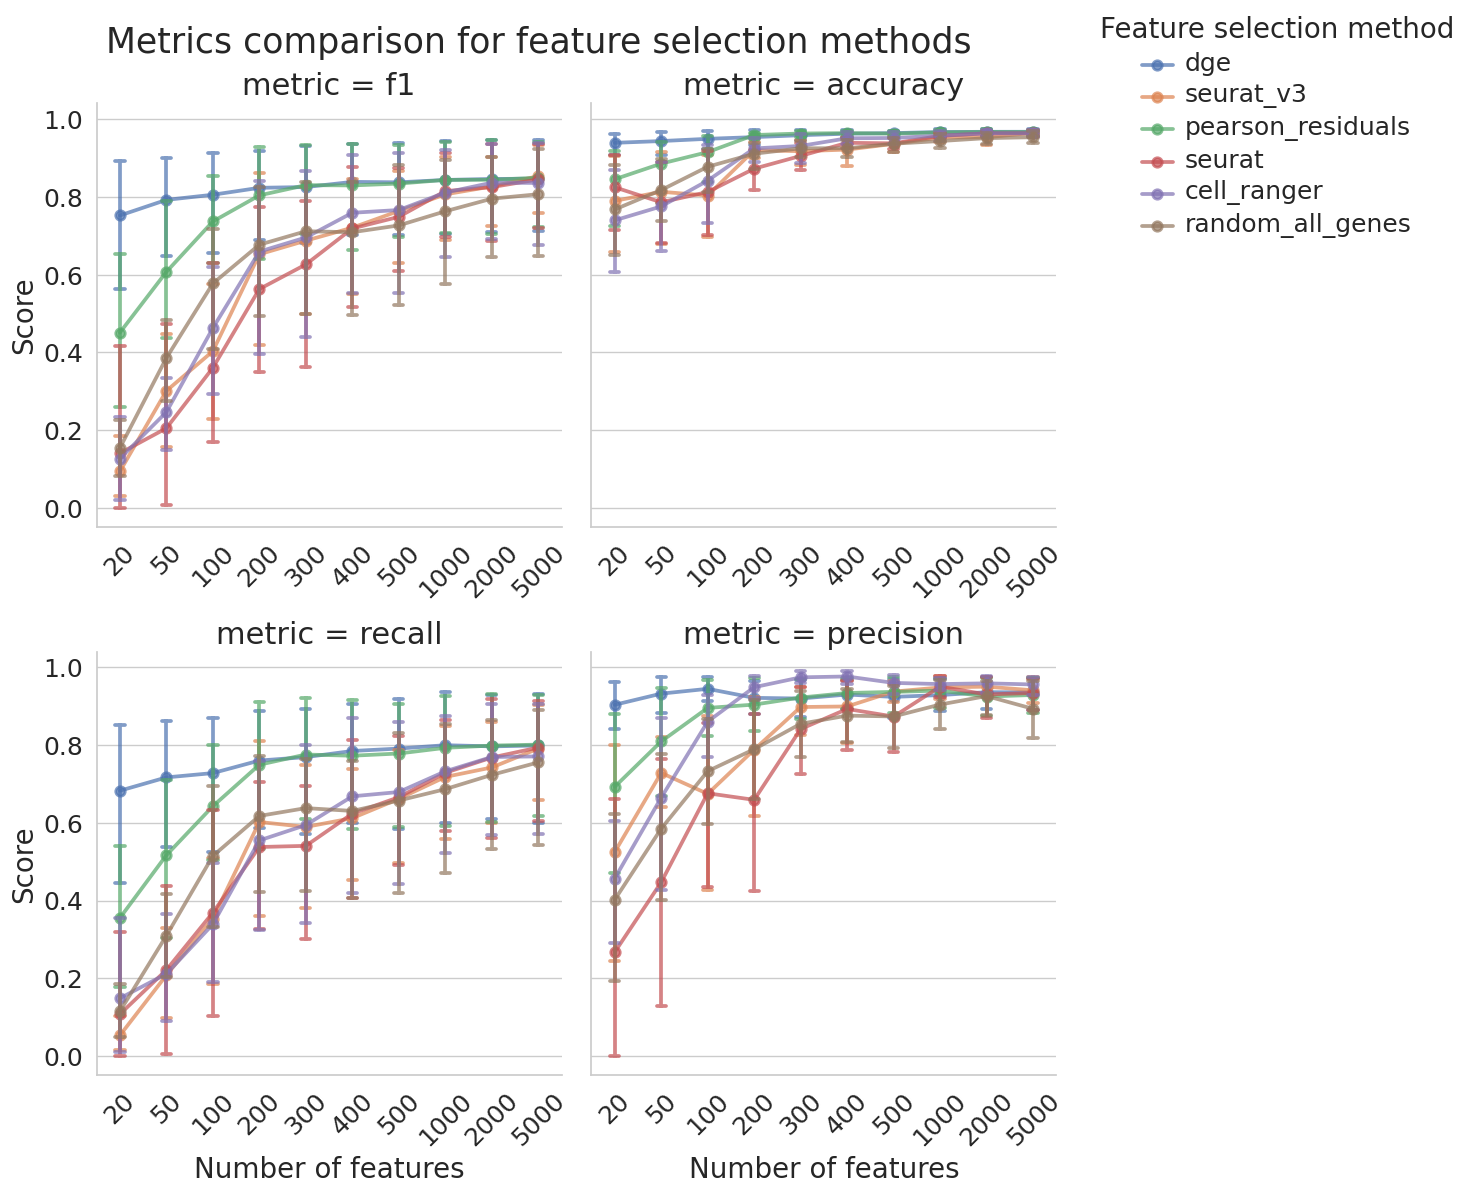

In [7]:
# Plot performance metrics
results_df = pd.read_csv('results_df_20241202.csv', index_col = 0)

results_df_pivot, fig = mf.make_line_plots_metrics(results_df)

## Main findings

* Comparison of methods
  * Differential gene expression (DGE) performs best until about 200 genes
  * For 200+ genes, DGE and analytic Pearson residuals have similar results
* Optimal number of features:
  * See sharp increase in scores until ~200-300, after which there is a gradual increase in scores

Conclusion: Use DGE or analytic Pearson residuals with 200 genes

# Feature importance

* Identify most important features in each fold
* Compare top features between different methods - want to understand why analytic Pearson residuals outperforms other methods

curr_method: dge
curr_num: 20


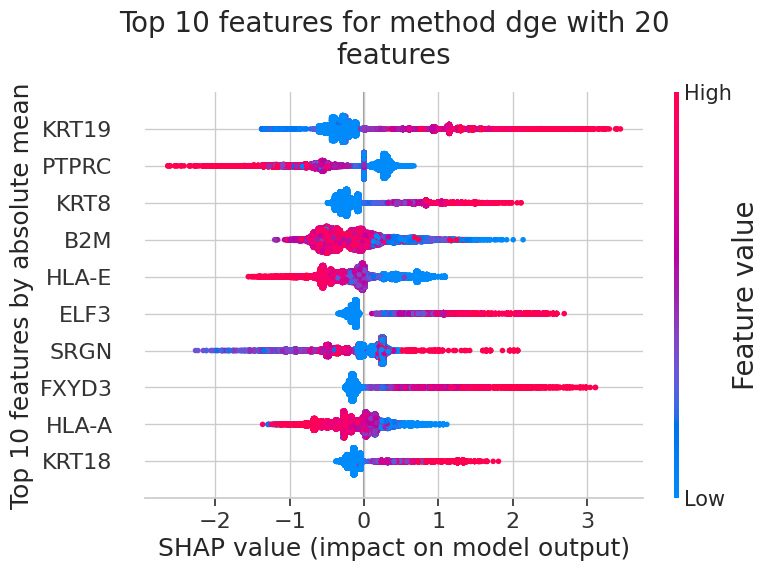

curr_num: 200


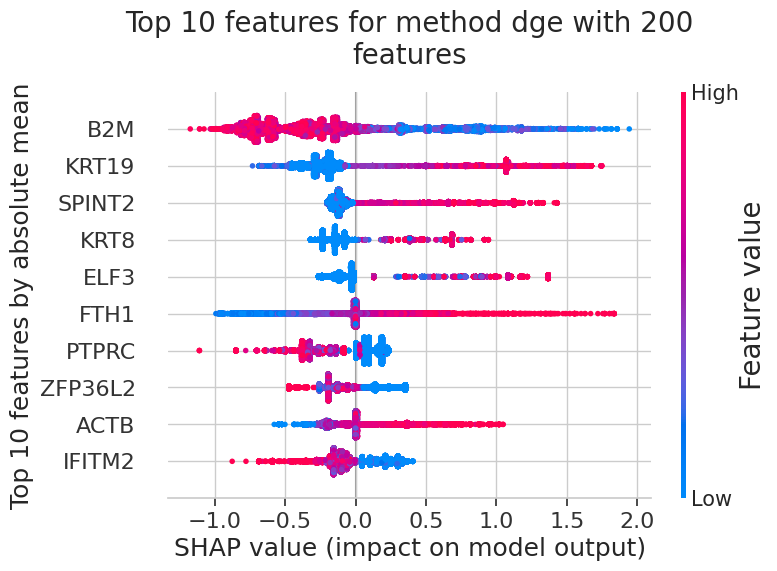

curr_method: pearson_residuals
curr_num: 20


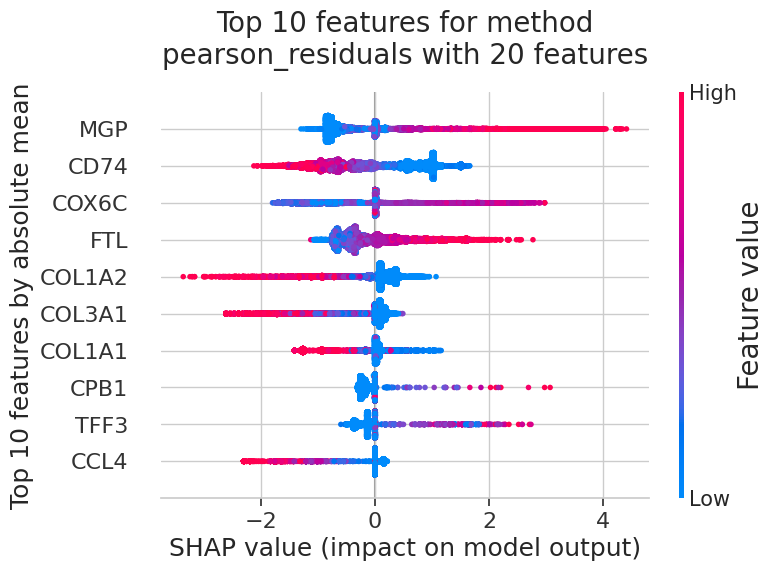

curr_num: 200


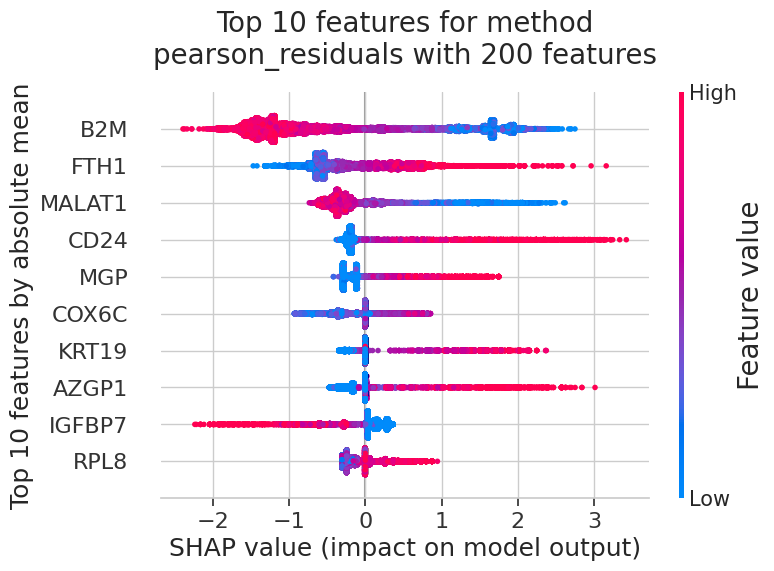

curr_method: random_all_genes
curr_num: 20


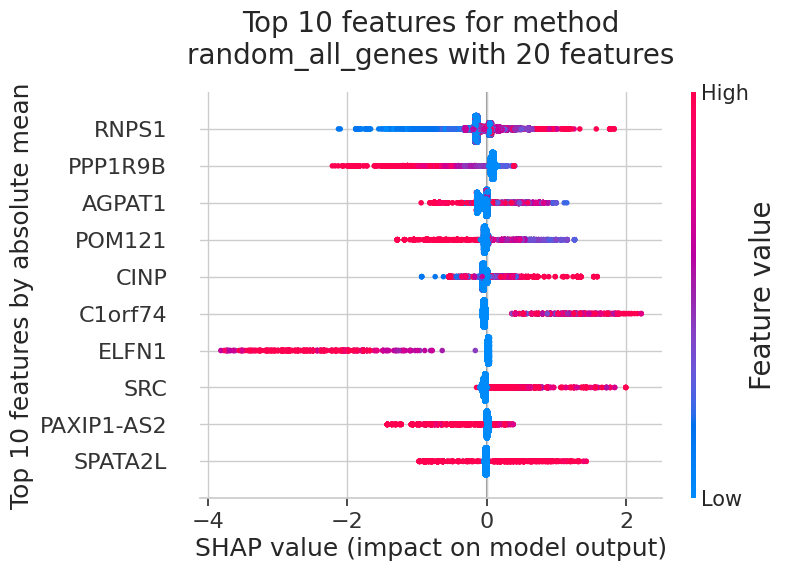

curr_num: 200


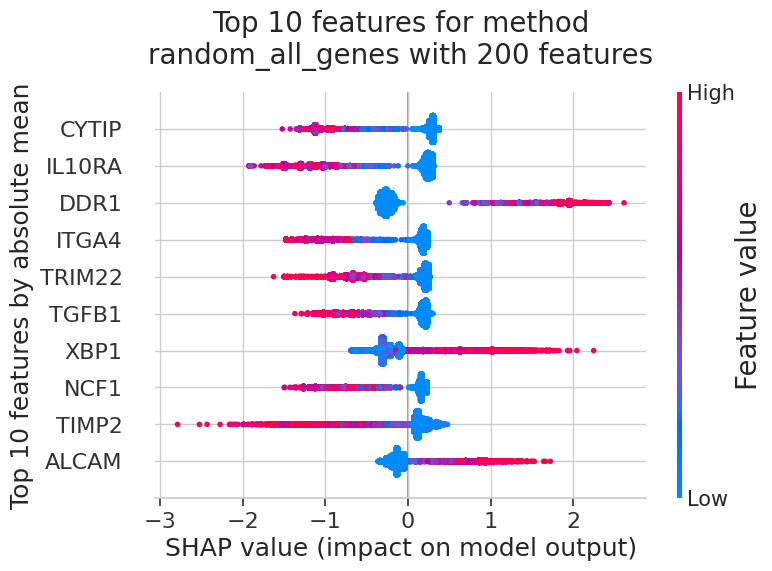

In [8]:
# Loop through methods and number of features to plot
num_features = [20, 200]
feat_sel_list = ['dge', 'pearson_residuals', 'random_all_genes']
file_prefix = '../outputs/20241202/'

for curr_method in feat_sel_list:
    print(f'curr_method: {curr_method}')
    for curr_num in num_features:
        print(f'curr_num: {curr_num}')
        fig = plt.figure()

        shap_vals_df, fig = mf.plot_feat_importance(adata_train, curr_method, curr_num,
                                            feat_order, shap_results, fold_index)
        # Create directory if not already created
        Path(file_prefix).mkdir(parents=True, exist_ok=True)
        # shap_vals_df.to_csv(f'{file_prefix}shap_vals_df_{method}_features{num_feat}.csv')

#        fig.savefig(f'{file_prefix}mean_beeswarm_{curr_method}_features{curr_num}.png', bbox_inches='tight')
        plt.close(fig)

In [9]:
# Calculate Jaccard coefficients between feature selection methods
df_jaccard = mf.calc_jaccard_coeff(feat_sel_list, num_features, feat_order, 5)

# Average Jaccard coefficients across folds
#df_jaccard = pd.read_csv('jaccard_df.csv', index_col = 0)
display(df_jaccard.head())
df_jaccard_mean = df_jaccard.groupby(['method1', 'method2', 'num_features'])['jaccard_coeff'].agg(['mean', 'std'])

,method1,method2,num_features,fold,jaccard_coeff
0,pearson_residuals,dge,20,0,0.000000
1,random_all_genes,dge,20,0,0.000000
2,random_all_genes,pearson_residuals,20,0,0.000000
3,pearson_residuals,dge,200,0,0.033592
4,random_all_genes,dge,200,0,0.007557
